# TT data analytics by RV ver2.0

# Settings libraries
##### please run the folowing cell

In [ ]:
#from IPython.display import Javascript
#Javascript("Jupyter.notebook.execute_cells([2,3])")
from IPython.display import IFrame
import ipywidgets as widgets
from ipywidgets import FileUpload
from IPython.display import Javascript
from ipyfilechooser import FileChooser
from ipywidgets import TwoByTwoLayout
from ipywidgets import GridspecLayout

import os
import csv
import pandas as pd
import numpy as np
import datetime as dt
import time
import math
from scipy.signal import savgol_filter

%matplotlib inline
import matplotlib.pyplot as plt
import smtplib 
from email.mime.multipart import MIMEMultipart 
from email.mime.text import MIMEText 
from email.mime.base import MIMEBase 
from email import encoders  
# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5000)
pd.options.mode.chained_assignment = None 
plt.rc('figure', max_open_warning = 0)


IFrame(src='https://rikvalentini.wixsite.com/naturetalkers', width=1000, height=1000)

# INPUT YOUR TT CLOUD NUMBER AND OPERATION MODE
> loop ON mode if you want to automatic updates every hour your data files, otherwise for single run do not check the box

In [ ]:

cloudID=widgets.Text('Input TTCLoud serial number')
display (cloudID)

loop_on=widgets.Checkbox(
    value=False,
    description='Loop ON',
    disabled=False,
    indent=False
)

display (loop_on)
time_cycle=widgets.Text('time cycle in seconds')
display (time_cycle)



# INPUT YOUR DATA FOLDER PATH
##### obligatory

In [ ]:


# selecting names directory --- the same folder will contain the elaborated files
fc = FileChooser('/Users/')
display(fc)
# fc.selected  is file path

# Input the Email addresses to send TTs battery report 
###### insert email addresses separated by commas (i.e. rik@unitus.it, rikvalentini@gmail.com,....)
> uncheck box if you do not want send emails

In [ ]:
#Mail messaging handling

if os.path.isfile(fc.selected_path+'/mail_params.csv') :

    
    with open (fc.selected_path+'/'+'mail_params.csv','r') as f:
            reader = csv.reader(f, delimiter=',')
            data_mail = next(reader)
    

    
            
else:
    
    data_mail[0]=''
    data_mail[1]=''
    data_mail[2]=''
    data_mail[3]=''
    data_mail[4]=''

mail_addr_from=widgets.Text(description='FROM',value=data_mail[0])
mail_addr_to=widgets.Text(description='TO',value=data_mail[1])
mail_smtp=widgets.Text(description='SMTP server',value=data_mail[2])
mail_port=widgets.Text(description='SMTP port',value=data_mail[3])
mail_pw=widgets.Text(description='Password',value=data_mail[4])
display (mail_addr_from)
display (mail_addr_to)
display (mail_smtp)
display (mail_port)
display (mail_pw)

mail_on=widgets.Checkbox(
    value=False,
    description='Send mail',
    disabled=False,
    indent=False
)

mail_store=widgets.Checkbox(
    value=False,
    description='Store mail addr',
    disabled=False,
    indent=False
)


display (mail_on)
display (mail_store)

# RUN THE CODE

In [41]:


#Data transformation in physical units
def transf():
    dfn['Tref_0c']=127.6-0.006045*dfn['Tref_0'] + 1.26E-07*dfn['Tref_0']**2 -1.15E-12*dfn['Tref_0']**3
    dfn['Tref_1c']=127.6-0.006045*dfn['Tref_1'] + 1.26E-07*dfn['Tref_1']**2 -1.15E-12*dfn['Tref_1']**3
    dfn['Theat_0c']=127.6-0.006045*dfn['Theat_0'] + 1.26E-07*dfn['Theat_0']**2 -1.15E-12*dfn['Theat_0']**3
    dfn['Theat_1c']=127.6-0.006045*dfn['Theat_1'] + 1.26E-07*dfn['Theat_1']**2 -1.15E-12*dfn['Theat_1']**3
    #dfn['growth_sensor_c']=194.856731-0.008274771*dfn.growth_sensor+1.63685E-07*dfn.growth_sensor**2-1.58251E-12*dfn.growth_sensor**3+ 5.96455E-18*dfn.growth_sensor**4
    dfn['growth_sensor_c']=0.000000008*(dfn['growth_sensor'])**2-0.0016*dfn['growth_sensor']+ 89.032#-0.0006*dfn['growth_sensor']+61.079
    dfn['angle_mean_c']=np.arctan((dfn['g_xmean']**2+(dfn['g_ymean']**2)/dfn['g_zmean'])**0.5)*90/(np.pi/2)
    dfn['trunk_axis_movement']=dfn['g_xstd']+dfn['g_ystd']+dfn['g_zstd']
    dfn['Vbat_c']= round(2*1100*dfn['adc_Vbat']/dfn['adc_bandgap']/1000,2)
    dfn['date'] = pd.to_datetime(dfn['timestamp'],unit='s').dt.tz_localize('UTC').dt.tz_convert('CET').dt.tz_localize(None)
    dfn['day']=dfn['date'].dt.strftime('%j').astype(float)
    dfn['hour']=dfn['date'].dt.strftime('%H').astype (float)
    dfn['doy']=dfn['day']+ dfn['hour']/24
    #dfn['date'].dt.tz_localize('utc').dt.tz_convert('Europe/Rome') in case of usimng EU time
    dfn['datetime'] = dfn['date'].dt.strftime('%d/%m/%Y/%H:%M:%S')
    
    dfn['air_temperature'] = dfn['air_temperature']/10
    

def time_check ():
    for j in range (0,len(dfn)-1):
        if dfn.loc[j,'timestamp'] < 1.59E9:
            dfn.drop ([j],axis=0,inplace =True)
    dfn.reset_index(drop=True, inplace=True)
    
def sav_gol_filter ():    
    #x = dfn['timestamp']
    dfn['Tref_0f'] = savgol_filter(dfn['Tref_0c'], 11, 2,mode='nearest') # window size 5, polynomial order 3
    dfn['Tref_1f'] = savgol_filter(dfn['Tref_1c'], 11, 2,mode='nearest') # window size 5, polynomial order 3
    dfn['Theat_0f'] = savgol_filter(dfn['Theat_0c'], 11, 2,mode='nearest') # window size 5, polynomial order 3
    dfn['Theat_1f'] = savgol_filter(dfn['Theat_1c'], 11, 2,mode='nearest') # window size 5, polynomial order 3
       

def elab_sapflow():
    
    #filtering temperature data using Savitzky–Golay filter
    
    
    #do equation   
    
    dfn['dTon']= dfn['Theat_1f']-dfn['Tref_1f']
    dfn['dToff']=dfn['Theat_0f']-dfn['Tref_0f']
    dfn['dTindex']=dfn['dTon']-dfn['dToff']
    
    #dfn['dTindex']=dfn['Theat_1f']-dfn['Tref_1f'] #just for granier
    dTmax= dfn.groupby(['day'])["dTindex"].max()
    

    for j in range (0,len(dfn)):
        try:
            dTmax_value = dTmax[dfn.loc[j,'day']]
        except:
            continue
         #to stabilize DTmax in night
        #if dfn.loc[j,'a_610']<10:
            #dfn.loc[j,'dTindex']=dTmax_value
        
        dfn.loc[j,'sap_flow_density_raw']=12.95*((dTmax_value/dfn.loc[j,'dTindex'])-1)*27.77 #transf from l dm-2 h-1 to g m-2 s-1
    
    
    
    dfn['sap_flow_density']=dfn.loc[0:len(dfn),'sap_flow_density_raw'].rolling(window=4).mean() # rolling mean of interpolated data
    
    # granier equation
    #dfn['dTindex']=dfn['Theat_1c']-dfn['Tref_1c']
    #for j in range (25,len(dfn)):
        #dTmax=dfn.loc[j-25:j,'dTindex'].max()
        #dfn.loc[j,'sap_flow_density']=118.99*10000*((dTmax/(dfn.loc[j,'dTindex'])-1))/3600 #transf from g m-2 s-1 to g cm-2 h-1
        
       
def elab_growth():
    
    dfn_night=dfn[dfn['a_650']==0]# select only night values
    dfn['growth_sensor_night']=dfn_night['growth_sensor_c']
    avg_g=dfn['growth_sensor_night'].median()# calculate median
    std_g=dfn['growth_sensor_night'].std()#calculate std
    
    for j in range (0,len(dfn)):
            if dfn.loc[j,'growth_sensor_night']>avg_g+2*std_g or dfn.loc[j,'growth_sensor_night']<avg_g-2*std_g: # correct for numbers outside +- 2*std
                dfn.loc[j,'growth_sensor_night']=avg_g #replace outliers with median 
    dfn.growth_sensor_night.interpolate(method='pad',axis=0, inplace=True) #interpolation of missing data NaN
    dfn['growth_roll']=dfn.loc[0:len(dfn),'growth_sensor_night'].rolling(window=200).mean() # rolling mean of interpolated data
    dfn['growth_roll_diff']=dfn['growth_roll'].diff() # derivative (growth) of the distance
    dfn.loc[dfn.growth_roll_diff>0,'growth_roll_diff']=0  #to be applied in case we want non-negative growth
    
    dfn['radial_growth']=-dfn['growth_roll_diff'].cumsum() # cumulative growth (negative since growth equal less distance from trunk)
    
    
    

def elab_stem_humidity():
    #dfn['stem_humidity']=((dfn.freq-(-74.149*dfn['Tref_0c']) + 33165)*-0.0001+1.9581)*100 # according to shahla
 
    a=-72.77*dfn['Tref_0f'] +22792 # probe in water sensitivity
    dfn['stem_humidity']=((1-(dfn.freq-a)/a))*100 # this is as reference to water 100%
   
      

def elab_light ():
   

    dfn.loc[dfn.a_610 >65532,'a_610']=np.nan
    dfn.loc[dfn.a_680 >65532,'a_680']=np.nan
    dfn.loc[dfn.a_730 >65532,'a_730']=np.nan
    dfn.loc[dfn.a_760 >65532,'a_760']=np.nan
    dfn.loc[dfn.a_810 >65532,'a_810']=np.nan
    dfn.loc[dfn.a_860 >65532,'a_860']=np.nan
    dfn.loc[dfn.a_450 >65532,'a_450']=np.nan
    dfn.loc[dfn.a_500 >65532,'a_500']=np.nan
    dfn.loc[dfn.a_550 >65532,'a_550']=np.nan
    dfn.loc[dfn.a_570 >65532,'a_570']=np.nan
    dfn.loc[dfn.a_600 >65532,'a_600']=np.nan
    dfn.loc[dfn.a_650 >65532,'a_650']=np.nan
    
    dfn['ndvi_raw']=(dfn.a_760-dfn.a_680)/(dfn.a_760+dfn.a_680)
    dfn.ndvi_raw.interpolate(method='pad',axis=0, inplace=True) #interpolation of missing data NaN
    dfn.loc[dfn.ndvi_raw <0,'ndvi_raw']=0
    dfn['ndvi']=dfn.loc[0:len(dfn),'ndvi_raw'].rolling(window=4).mean() # rolling mean of interpolated data
    
    dfn['green_red_raw']=(dfn.a_570-dfn.a_680)/(dfn.a_570+dfn.a_680)
    dfn.green_red_raw.interpolate(method='pad',axis=0, inplace=True) #interpolation of missing data NaN
    dfn.loc[dfn.green_red_raw <0,'green_red_raw']=0
    dfn['green_red']=dfn.loc[0:len(dfn),'green_red_raw'].rolling(window=4).mean() # rolling mean of interpolated data

    
#Showing batteries voltage
def Vbat_show():
    print (names_tt[i],dfn.loc[len(dfn)-1,'Vbat_c'],dfn.loc[len(dfn)-1,'date'])
    #dt.datetime.fromtimestamp(1596725594).strftime('%Y-%m-%d %H:%M:%S %j' )

    
#Sending report check
def Vbat_mail():
    
    toaddr = data_mail[1].split(',') # this create a list of mail addresses
    fromaddr = data_mail[0]
    smtp=data_mail[2]
    port=data_mail[3]
    pw=data_mail[4]
    
    
     # instance of MIMEMultipart 
    msg = MIMEMultipart() 
      
    # storing the senders email address   
    msg['From'] = fromaddr 
      
    # storing the receivers email address  
  
    msg['To'] = ', '.join(toaddr)
    # storing the subject  
    msg['Subject'] = cloudID_tt
      
    # string to store the body of the mail 
    body = "Battery test"
      
    # attach the body with the msg instance 
    msg.attach(MIMEText(body, 'plain')) 
      
    # open the file to be sent  
    filename = url_proj+'/'+cloudID_tt+'_BAT_'+day+'.csv'
    attachment = open(filename, "rb") 
      
    # instance of MIMEBase and named as p 
    p = MIMEBase('application', 'octet-stream') 
      
    # To change the payload into encoded form 
    p.set_payload((attachment).read()) 
      
    # encode into base64 
    encoders.encode_base64(p) 
       
    p.add_header('Content-Disposition', "attachment; filename= %s" % cloudID_tt+'_BAT_'+day+'.csv') 
      
    # attach the instance 'p' to instance 'msg' 
    msg.attach(p) 
      
    # creates SMTP session 
    s = smtplib.SMTP_SSL(smtp, port) 
      
    # start TLS for security 
    #s.starttls() 
      
    # Authentication 
    s.login(fromaddr, pw) 
      
    # Converts the Multipart msg into a string 
    text = msg.as_string() 
      
    # sending the mail 
    s.sendmail(fromaddr, toaddr, text) 
      
    # terminating the session 
    s.quit() 

#----------------MAIN programme start--------------------




url_proj= fc.selected_path

    # Store mail parameters

if mail_store.value:
    
    with open (url_proj+'/'+'mail_params.csv','w') as f:
               
                data_writer = csv.writer(f, delimiter=',')
                data_writer.writerow(data_mail)


    #READ THE CLOUD    

flag_bat=1
cloudID_tt=cloudID.value


#TTcloud_tt=url_site+cloudID_tt

cols=['timestamp','tree_talker', 'sap_flow_density','stem_humidity','radial_growth','ndvi','green_red','air_temperature','rel_air_humidity','trunk_axis_movement']

#dfn_cum=pd.DataFrame(columns=cols) 
dfn_day=pd.DataFrame(columns=cols) 

d=dt.datetime.now()
old_day=d.strftime('%d.%m.%Y')
        
        
while True:
  
        
        t0=time.time()
        ts = str(int(time.time()))
       
       
        
        
        while True :
            try:
                    print ("job start at ... ",dt.datetime.now())
                    url_tt = 'http://naturetalkers.altervista.org/'+cloudID_tt+'/ttcloud.txt'
                    df_tt=pd.read_csv(url_tt, sep=',',engine='python',header=None)
                    
            except:
                    print ("altervista server failure .....")
                    time.sleep(6)
                    pass
            else:
                    break



        
       
        
        # search for TTs names
        names_tt=[]
        for j in range (len(df_tt)-1):
                if  df_tt.loc[j+1,1].split(';')[0] !=  df_tt.loc[j,1].split(';')[0]:
                    names_tt.append(df_tt.loc[j,1].split(';')[0])
        names_tt = list(dict.fromkeys(names_tt))
        names_tt.remove(cloudID_tt)  
        
        #dtt=pd.read_csv(fc.selected, sep=',',index_col=False, engine='python',header=0)
        #dtt.ID=dtt.ID.astype(str)
      
     
        print ('Data retrieval time seconds .....',time.time()-t0)
        print ('waiting elaboration.....')
        t1=time.time()
               
        #CREATE DATAFRAME FOR TT AND TT FIRE
        
        a=[]
        col0=df_tt.iloc[:,0].to_list()
        col1=df_tt.iloc[:,1].to_list() 
        for i in range (len(col1)):
                a.append(col1[i].split(';'))
        dfraw=pd.DataFrame(a)
        df_tt=dfraw
        #df_tt=dfraw[480*31:len(dfraw)] # we take data after 240 hours of stabilizatio (10 days)
        df_tt.reset_index(drop=True,inplace=True)
        
               
               
        
        #TREE TALKER SECTION
        
        #CLEANING DATAFRAME GENERATING COMBINED STRING 49 AND 4D FOR ID of treetalkers
        
      
        
        
        
        #dfn_cum.to_csv (url_names+'_'+day+'.csv',index=False)
        df_Vbat=pd.DataFrame(columns=['ID','date','Vbat'])


        for i in range (0,len(names_tt)):
                dfn_day=pd.DataFrame(columns=cols)
                dfx=df_tt[df_tt.iloc[:,0]==names_tt[i]]
                if len(dfx)==0:
                    print (names_tt[i], 'missing')
                    row_bat=[names_tt[i],old_day,'missing']                 
                    df_Vbat.loc[len(df_Vbat)]=row_bat
                    continue
            
                dfn1=dfx[dfx.iloc[:,2]=='4D']
                col_delete=[1,2,21,22,23,24,25,26,27,28,29] 
                dfn1.drop(col_delete,axis=1,inplace =True)
                col1=['tree_talker','timestamp','Tref_0','Theat_0','growth_sensor',
                'adc_bandgap','bits','rel_air_humidity','air_temperature','g_zmean','g_zstd','g_ymean','g_ystd','g_xmean','g_xstd','Tref_1','Theat_1','freq','adc_Vbat']
                dfn1.columns=col1
                dfn1.drop_duplicates(subset=None, inplace=True)
                dfn1.reset_index(drop=True, inplace=True)
                
                dfn2=dfx[dfx.iloc[:,2]=='49']
                col_delete=[1,2,18,19,20,21,22,23,24,25,26,27,28,29] 
                dfn2.drop(col_delete,axis=1,inplace =True)
                col2=['tree_talker','timestamp','a_610','a_680','a_730','a_760','a_810','a_860','a_450','a_500','a_550','a_570','a_600','a_650','integration_time','gain']
                dfn2.columns=col2
                dfn2.drop_duplicates(subset=None, inplace=True)
                dfn2.reset_index(drop=True, inplace=True)
                
                dfn=pd.merge(dfn1,dfn2,on=['tree_talker','timestamp'])
                dfn.drop_duplicates(subset=None, inplace=True)
                dfn.reset_index(drop=True, inplace=True)
                
                dfn.timestamp=dfn.timestamp.astype(int)
                dfn.timestamp=round(dfn.timestamp/10)*10
                for j in dfn.columns[2:32]:
                    dfn[j]=dfn[j].astype(float)
               
                dfn['timestamp']=dfn['timestamp'].astype(int)
                time_check()
                dfn.to_csv(url_proj+'/'+names_tt[i]+'_raw.csv',index=False)
                transf()
                dfn.to_csv(url_proj+'/'+names_tt[i]+'_transf.csv',index=False)
                
               
                #Vbat_show()
               
                sav_gol_filter ()
                elab_sapflow()
                elab_growth()
                elab_stem_humidity()
                elab_light()
                
                row_bat=[dfn.loc[len(dfn)-1,'tree_talker'],dfn.loc[len(dfn)-1,'datetime'],dfn.loc[len(dfn)-1,'Vbat_c']]          
                df_Vbat.loc[len(df_Vbat)]=row_bat
                
                dfn_final = dfn[['tree_talker', 'timestamp','doy','air_temperature','rel_air_humidity','sap_flow_density','stem_humidity','radial_growth','a_610','a_680','a_730','a_760','a_810','a_860','a_450','a_500','a_550','a_570','a_600','a_650','ndvi','green_red','trunk_axis_movement']].copy()
                dfn.to_csv(url_proj+'/'+names_tt[i]+'_elab.csv',index=False)
                dfn_final.to_csv(url_proj+'/'+names_tt[i]+'_final.csv',index=False)
                
                
                dfn_c=dfn[['tree_talker', 'timestamp','date','sap_flow_density','stem_humidity','radial_growth','ndvi','green_red','air_temperature','rel_air_humidity','trunk_axis_movement']]
                dfn_c.reset_index(drop=True, inplace=True)
                
             
                d=dt.datetime.now()
                day=d.strftime('%d.%m.%Y')
                last_date = pd.to_datetime(dfn_c.loc[len(dfn_c)-1,'timestamp'],unit='s')
    
                last_date=last_date.strftime('%d/%m/%Y/%H:%M:%S')
                #dfn_c['date']=last_date
                #dfn_cum.loc[len(dfn_cum)]=dfn_tot.loc[len(dfn_tot)-1]
                
               
                dfn_day.loc[len(dfn_day)]=dfn_c.loc[len(dfn_c)-1]
                
                file_day =url_proj+'/'+cloudID_tt+'_'+day
                if os.path.exists(file_day+'.csv'):
                    bol=False
                else:
                    bol=True
                with open(file_day+'.csv','a+') as f:
                           dfn_day.to_csv(f,index=False,header=bol)
                
              
                
        
        
              
      
        df_Vbat.to_csv(url_proj+'/'+cloudID_tt+'_BAT_'+day+'.csv',index=False)
        
        if (day != old_day or flag_bat==1) and mail_on.value:# flag 1 only when you start script for the first time
            Vbat_mail()
            old_day=day
            flag_bat=0
       
        
       
        print ('TT total elaboration time seconds .....',time.time()-t1)
        display (df_Vbat)
        
        
       
        if loop_on.value:
            time.sleep(time_cycle.value)
        else:
            print ('job ended')
            break
            
        print('Waiting next job .......')

job start at ...  2020-10-04 18:05:33.416325
Data retrieval time seconds ..... 11.339653253555298
waiting elaboration.....
TT total elaboration time seconds ..... 48.85919404029846


,ID,date,Vbat
0,52060619,04/10/2020/17:00:00,4.09
1,52060641,04/10/2020/17:00:00,4.08
2,52060607,04/10/2020/17:00:00,4.07
3,52060611,04/10/2020/17:00:00,4.21
4,52060596,04/10/2020/17:00:00,4.14
5,52060593,04/10/2020/17:00:00,4.21
6,52060594,04/10/2020/17:00:00,4.08
7,52060628,04/10/2020/17:00:00,4.11
8,52060622,04/10/2020/17:00:00,4.11
9,52060591,04/10/2020/17:00:00,4.16


job ended


# SELECT single TT
##### select variables (doy= julian date and it is fixed)

In [35]:
TT_name=widgets.Dropdown(
    options=names_tt,
    value=names_tt[0],
    description='Select TT:',
    disabled=False,
)

variable_name_x=widgets.Dropdown(
    options=dfn_final.columns,
    value=dfn_final.columns[2],
    description='X:',
    disabled=True,
)
variable_name_y=widgets.Dropdown(
    options=dfn_final.columns,
    value=dfn_final.columns[5],
    description='Y:',
    disabled=False,
)


#display (TT_name)

TwoByTwoLayout(top_left=TT_name,
               bottom_left=variable_name_x,
               bottom_right=variable_name_y,
               merge=False)



TwoByTwoLayout(children=(Dropdown(description='Select TT:', layout=Layout(grid_area='top-left'), options=('520…

# RUN the single graph

In [36]:
dfn=pd.read_csv(url_proj+'/'+TT_name.value+'_final.csv', sep=',',engine='python',header=0)

def f(xmin,xmax,ymin,ymax):
    
    
    plt.figure(figsize=(15,4))
    plt.title(TT_name.value)

        ##plt.ylim(61000,70000)
    #plt.plot(dfn['doy'],dfn['dTindex'],color='y')
    plt.plot(dfn[variable_name_x.value],dfn[variable_name_y.value],color='r')
    #plt.plot(dfn[variable_name_x.value],dfn['Tref_0f'],color='b')
    
    #plt.plot(dfn['doy'],dfn[variable_name_y.value],color='b')
    #plt.plot(dfn['doy'],dfn['dTindex'],color='b')

#y_filt = savgol_filter(dfn['Tref_0c'], 5, 3) # window size 51, polynomial order 3
#matplotlib.pyplot
#plt.plot_date(dates, values)

#plt.plot(x,y)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    return 

xmin = widgets.IntSlider(description='xmin:',min=0,max=365,value=200)
xmax = widgets.IntSlider(description='xmax:',min=0,max=365,value=300)
ymin = widgets.IntSlider(description='ymin:',min=0,max=100,value=0)
ymax = widgets.IntSlider(description='ymax:',min=0,max=300,value=30)

ui = widgets.HBox([xmin, xmax,ymin,ymax])
out = widgets.interactive_output(f, {'xmin': xmin,'xmax':xmax,'ymin': ymin,'ymax':ymax})
display(ui, out)

Output()

# Select all TTs and  set graphs
##### select y variable and x, y ranges

In [39]:
grid = GridspecLayout(3, 2)

variable_name_x=widgets.Dropdown(
    options=dfn_final.columns,
    value=dfn_final.columns[2],
    description='X:',
    disabled=True,
)
variable_name_y=widgets.Dropdown(
    options=dfn_final.columns,
    value=dfn_final.columns[5],
    description='Y:',
    disabled=False,
)

xmin = widgets.IntSlider(description='xmin:',min=0,max=365,value=200)
xmax = widgets.IntSlider(description='xmax:',min=0,max=365,value=300)
ymin = widgets.IntSlider(description='ymin:',min=0,max=100,value=0)
ymax = widgets.IntSlider(description='ymax:',min=0,max=300,value=30)

grid[0,0]=variable_name_x
grid[0,1]=variable_name_y
grid[1,0]=xmin
grid[1,1]=xmax
grid[2,0]=ymin
grid[2,1]=ymax



#display (TT_name)
grid



GridspecLayout(children=(Dropdown(description='X:', disabled=True, index=2, layout=Layout(grid_area='widget001…

# RUN all graphs

ValueError: x and y must have same first dimension, but have shapes (1850,) and (1774,)

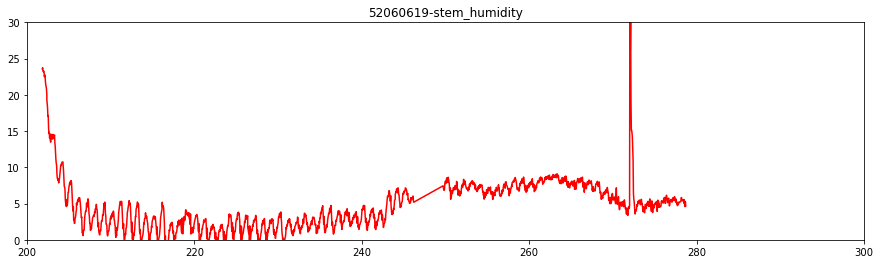

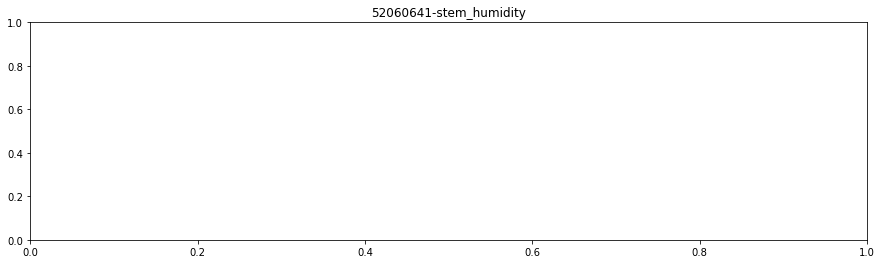

In [40]:

for i in names_tt:
    
    dfn_final=pd.read_csv(url_proj+'/'+i+'_elab.csv', sep=',',engine='python',header=0)
    
    
    plt.figure(figsize=(15,4))
    plt.title(i+"-"+variable_name_y.value)
    plt.plot(dfn_final[variable_name_x.value],dfn[variable_name_y.value],color='r')
    
    plt.xlim(xmin.value,xmax.value)
    plt.ylim(ymin.value,ymax.value)
    
          
           

          

In [17]:
names_tt

'doy'

In [28]:
dfn=dfn[dfn['stem_humidity']<=80]

In [29]:
dfn.stem_humidity

0     -15.253509
1     -15.648287
2     -15.082395
3     -14.789635
4     -14.988546
5     -14.705742
6     -14.413253
7     -13.749830
8     -13.590015
9     -13.383025
10    -13.655685
11    -13.443644
12    -13.430944
13    -13.051289
14    -13.543255
15    -13.514736
16    -13.159009
17    -13.905138
18    -14.398879
19    -14.344379
20    -14.810951
21    -15.115946
22    -15.578053
23    -15.686878
24    -15.556059
25    -15.532639
26    -15.364590
27    -14.718493
28    -14.895207
29    -14.183000
30    -13.985562
31    -14.256424
32    -13.683557
33    -13.488110
34    -13.726634
35    -13.253336
36    -13.694691
37    -13.734440
38    -13.962188
39    -13.260973
40    -14.058069
41    -14.405258
42    -14.447481
43    -14.829004
44    -15.542598
45    -15.585930
46    -15.450764
47    -15.849462
48    -15.515049
49    -15.888250
50    -15.788965
51    -15.066425
52    -14.770555
53    -14.933955
54    -14.777229
55    -14.254068
56    -14.615378
57    -14.535345
58    -14.3542